In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.metrics import confusion_matrix
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

nlp = spacy.load('en')

pd.options.display.max_colwidth = 5000
pd.options.display.max_rows = 5000
    

In [2]:
# #-------- Check spelling variations of the word bachelors------------
# test = ' '.join(raw_data.description)

# matches = re.finditer("(^|(?<=\W))(b.\a|ba|bachlr|bachelor|b\.\s\.|bs|b\.s)[s']?[s']?((?=\W)|$)", test )

# c = Counter()
# for item in matches:
#     c[item.group(0)] += 1
    
# print(c)

In [3]:
#--------- Load the data ---------------
raw_data = pd.read_table('alldata.csv', delimiter=',')
print('Shape Raw Data : ' + str(raw_data.shape))

#--------Clean the Data ---------------

#Handle Missing Data
raw_data.dropna(how='all', inplace=True)
raw_data['reviews'].fillna(0,inplace=True)


#Filter out outliers(exceptionally large job descriptions)
def funct_get_size(row):
    return len(row.description)

raw_data['review_size'] = raw_data.apply(funct_get_size, axis=1)
raw_data = raw_data[raw_data.review_size < 10000]


#clean the text
raw_data.description = raw_data.description.str.lower()
raw_data.description = raw_data.description.replace("(equal).{1,20}(employ)(er|ment)", 'eoe', regex=True)
raw_data.description = raw_data.description.replace('eeo', 'eoe')
raw_data.description = raw_data.description.replace("(^|(?<=\W))(mastr|mster|master|m\.\s\.|ms|m\.s)[s']?[s']?((?=\W)|$)", 'masters', regex=True)
raw_data.description = raw_data.description.replace("(^|(?<=\W))(b.\a|ba|bachlr|bachelor|b\.\s\.|bs|b\.s)[s']?[s']?((?=\W)|$)", 'bachelors', regex=True)
raw_data.description = raw_data.description.replace("p[h\.\-\_(]{1,3}d\.?", 'phd', regex=True)
raw_data.description = raw_data.description.replace("(?<=\W)m[b\.]{1,3}a\.?", 'mba', regex=True)
raw_data.description = raw_data.description.replace('[\\/-]',' ',regex=True)
raw_data.description = raw_data.description.replace('(?<=\w)([.,;:])(?=\w)','\g<1> ', regex=True)
raw_data.description = raw_data.description.replace('(?<=\W)r\.(?=\W)','r',regex=True)
raw_data.description = raw_data.description.replace('nlp','natural language processing',regex=True)
raw_data.description = raw_data.description.replace('consumer packaged goods','cpg',regex=True)
raw_data.description = raw_data.description.replace('consumer goods','cpg',regex=True)
#raw_data.description = raw_data.description.replace('&amp','&',regex=False)
raw_data.location = raw_data.location.str.strip()
raw_data['city'] = raw_data.location.str.replace('(\w+)[,\s]{1,2}([A-Z]{2})\s?\d*','\g<1>')
raw_data['state'] = raw_data.location.str.replace('^(.*?)[,\s]{1,2}([A-Z]{2})\s?\d*','\g<2>')
raw_data['city'] = raw_data.city.str.replace('.*?San Francisco.*','San Francisco')


print('Shape Raw Data After Handling Missing Values : ' + str(raw_data.shape))

Shape Raw Data : (6964, 5)
Shape Raw Data After Handling Missing Values : (6897, 8)


In [4]:
#------  Parse the corpus of job descriptions into a single list of sentences -----------

def function_create_sentence_list(all_postings, remove_large=False):
    
    sentences = all_postings.split('\n')

    #print('Number of sentences: ' + str(len(sentences))) 
    
    save_for_next = ''
    cleaned_sentences = []
  
    for sentence in sentences:
        size = len(sentence)
      
        if (size > 250) & (remove_large==True):
            continue  #don't add
            
        elif size < 40:
            save_for_next = sentence

        else:
            if save_for_next == '':
                cleaned_sentences.append(sentence)
            else:
                cleaned_sentences.append(save_for_next + ' ' + sentence)
                save_for_next = ''

    #print('Number after combining small sentences: ' + str(len(cleaned_sentences))) 
    return cleaned_sentences



cleaned_sentences = function_create_sentence_list(' '.join(raw_data.description.values), remove_large=True)
print('Number of sentences after cleaning and combining: ' + str(len(cleaned_sentences)))

Number of sentences after cleaning and combining: 105967


In [5]:
my_stop_list = ['to', 'and', 'for', 'that', 'is', 'the', 'or', 'to', 'of', 'this', 'in', 'as', 'an', 'at', 'with']


my_weighted_words = ['must', 'requirement', 'required', 'requirements',
                'minimum', 'year', 'years', 'yr', 'experience',
                'exp', 'support', 'execute', 'manage', 'perform',
                'build', 'develop', 'create', 'maintain', 'oversee',
                'monitor', 'work with', 'work closely', 
                'integrate', 'lead', 'masters', 'bachelors', 'phd',
                'equivalent', 'degree', 'sql', 'python', 'pytorch',
                'tensorflow', 'spark', 'expert', 'language', 'program',
                'programming', 'c++', 'c', 'r', 'javascript', 'java',
                'hadoop', 'scikit', 'respond to', 'we', 'opportunity',
                'ability', 'engineering', 'computer science', 'computer',
                'university', 'school', 'familiarity', 'knowledge'
                'understanding', 'communication', 'verbal', 
                'data', 'written', 'presentation', 'presentations', 'provide',
                'demonstrate', 'our', 'you', 'team', 'knowledge', 
                'collaborate','troubleshoot', 'establish', 'obtain',
                'collect', 'understanding', 'learn', 'demonstrated', 'track record',
                'proven', 'help', 'partner', 'partners',
                'clients', 'vendors', 'enhance',
                'serve', 'deliver', 'innovation', 'opportunities',
                'stakeholders', 'market', 'you will', 'your',
                'ecosystem', 'enterprise', 'leading', 'partnerships', 'success',
                'generation', 'recruit', 'ai', 'drive', 'define', 'improve', 'ensure',
                 'implement', 'skills', 'foster', 'identify', 'use', 'partner with',
                'automate', 'test', 'benefits', 'offer', 'culture', 'best place',
                'employees', 'weve', "we've", "we're", 'position', 'located', 'opening',
                'responsibilities', 'responsible for', 'generate', 'must have', 'coordinate',
                'advise on', 'champion', 'direct', 'represent', 'customer', 'goals', 'activities',
                'role', 'roles', 'deploy']




In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

print('Adding Features to {} sentences.'.format(len(cleaned_sentences)))
      
#---------------------  VECTORIZE THE LIST  -----------------------
vectorizer = CountVectorizer( #tokenizer=my_tokenizer,
         ngram_range=(1,6),
         strip_accents=None,  
         max_df = 1.0,
         min_df = 5,
         lowercase=True,
         max_features = 1000,
         #stop_words='english'
         #stop_words=my_stop_list
         #vocabulary=my_vocabulary
    )


#Applying the vectorizer 
#Takes in a list of documents and applies features
#return a sparse matrix
sentences_counts=vectorizer.fit_transform(cleaned_sentences)


#--------------  Put Vector results into dataframe ----------
#Convert sparse matrix into a dataframe
features = vectorizer.get_feature_names()
sentences_counts_verbose = np.array(sentences_counts.A, dtype='f')
sentences_by_feature = pd.DataFrame(sentences_counts_verbose, index=cleaned_sentences[0:], columns=features)

print('Shape after vectorizing: ' + str(sentences_counts_verbose.shape))

#Apply a weight to a set of words
for word in my_weighted_words:
        try:
                sentences_by_feature[[word]] = sentences_by_feature[[word]] * 500
        except:
            continue
        
    
print('Applied a weight to a set of features')

#---------------------  REDUCE FEATURES VIA PCA / SVD -----------------------
print('Running SVD to reduce feature space from {} features'.format(sentences_by_feature.shape[1]))
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
svd= TruncatedSVD(2)
svd_features = svd.fit_transform(normalize(sentences_by_feature)) 
print('Shape after running SVD: ' + str(svd_features.shape))


#---------------------  EXPLAINING VARIANCE FROM PCA -----------------------      
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)
sentences_by_component=pd.DataFrame(svd_features, index=sentences_by_feature.index)

#
for i in range(2):
     print('-------------------------------------------------------------')
     print('---------Component {}----------------------------------------'.format(i))
     print('-------------------------------------------------------------')
     print(sentences_by_component.loc[:,i].sort_values(ascending=False)[0:10])


print('done')

Adding Features to 105967 sentences.
Shape after vectorizing: (105967, 1000)
Applied a weight to a set of features
Running SVD to reduce feature space from 1000 features
Shape after running SVD: (105967, 2)
Percent variance captured by all components: 16.213015205556147
-------------------------------------------------------------
---------Component 0----------------------------------------
-------------------------------------------------------------
experience with biological data sets experience in writing sops and study protocols                                                                                    0.977171
experience in design of experiments and statistical data analysis (access and jmp experience preferred)                                                                0.977171
experience working in a biomedical laboratory and or experience with clinical trials and data management                                                               0.977171
experience in ra

In [7]:
#---- TEST A SINGLE JOB DESCRIPTION - TO SEE IF IT CLASSIFIED THE SENTENCES CORRECTLY 


test_text = raw_data.loc[452,'description']
cleaned_test_text = function_create_sentence_list(test_text, remove_large=False)

sentences_counts_test=vectorizer.transform(cleaned_test_text)

sentences_counts_verbose_test = np.array(sentences_counts_test.A, dtype='f')
sentences_by_feature_test = pd.DataFrame(sentences_counts_verbose_test, index=cleaned_test_text, columns=features)
#print('Shape after vectorizing: ' + str(sentences_by_feature_test.shape))


svd_features = svd.transform(normalize(sentences_by_feature_test))
#print('Shape after running SVD: ' + str(svd_features.shape))

#---------------------  EXPLAINING VARIANCE FROM PCA -----------------------      
variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
#print("Percent variance captured by all components:",total_variance*100)
test_results =pd.DataFrame(svd_features, index=sentences_by_feature_test.index)

test_results.columns=['About the Candidate','About the Job']
test_results

,About the Candidate,About the Job
apple’s strategic data solutions (sds) team leads efforts to optimize various business processes and improve the customer journey across apple. we apply data science and machine learning to drive strategic impact across multiple lines of business at apple. we are looking for an excellent analyst who is passionate about working closely with partner teams; understanding their processes and analytic needs; and developing technical solutions along the way.,0.090795,0.202390
"you will sit side by side with our data scientists and analyze complex business problems, have access to internal and external data sources, and be expected to communicate meaningful insights to senior leadership and key decision makers. you should work well in team driven environments with minimal formal structure and at ease in uncertain environments with opposing priorities. you should possess extraordinary business sense, a strong quantitative technical background, natural curiosity, and the ability to effectively shift between communications styles based on the audience (technical peer review through leadership update).",0.078417,0.170807
key qualifications experience applying analytical techniques to provide solutions to real business problems,0.220290,-0.089562
experience with sql and big data systems and tools,0.351519,0.141985
programming skills in python or similar language,0.037130,0.006804
experience eliciting business requirements and executive metrics,0.412169,-0.170468
experience building business cases and project plans,0.341119,-0.146549
good social skills with ability to connect and develop positive partnerships,0.026619,0.034618
strong verbal written communication skills,0.022547,0.014797
(desired) background in payments or financial auditing,0.000721,0.000070


In [8]:
#Classify each of the sentences as "About the Candidate" or "About the job" 
#-- it is based on the component feature with the higher score

sent_descriptions = []
job_numbers = []
job_locations = []
job_companies = []
job_positions = []
job_descriptions = []
sent_classifications = []

raw_data['job_number'] = raw_data.index

for i, row in raw_data[:].iterrows():
    
    size = raw_data.shape[0]
    
    if i % 1000 == 0:
        print('Processing {} of {}'.format(i,size))
    
    job_description = row.description
    job_number = row.job_number
    job_location = row.location
    job_company = row.company
    job_position = row.position
    
    job_cleaned_sentences = function_create_sentence_list(job_description, remove_large=False)
              
    sentences_vectorized =vectorizer.transform(job_cleaned_sentences)
    sentences_vectorized_verbose = np.array(sentences_vectorized.A, dtype='f')
    #sentences_by_feature_test = pd.DataFrame(sentences_counts_verbose_test, index=cleaned_test_text, columns=features)
    
    if len(job_cleaned_sentences) == 0:
        continue  #skip this job description.  It is too short.
    
    svd_features = svd.transform(sentences_vectorized_verbose)
    
    for c, sentence in enumerate(job_cleaned_sentences):
        job_numbers.append(job_number)
        job_locations.append(job_location)
        job_companies.append(job_company)
        job_positions.append(job_position)
        job_descriptions.append(job_description)
        sent_descriptions.append(sentence)
        
        
        
        if svd_features[c,0] > svd_features[c,1]:
            sent_classifications.append('About the ideal candidate')
        elif svd_features[c,0] < svd_features[c,1]:
            sent_classifications.append('About the position')
        else:
            sent_classifications.append('Unable to classify')
    
print('done')

Processing 0 of 6897
Processing 1000 of 6897
Processing 2000 of 6897
Processing 3000 of 6897
Processing 4000 of 6897
Processing 6000 of 6897
done


In [9]:
#Display results of sentence classification

df_results = pd.DataFrame({'job_number': job_numbers,
                            'position': job_positions,
                           'company': job_companies,
                           'location': job_locations,
                           'sentence': sent_descriptions,
                           'sentence_class': sent_classifications,
                           #'description': job_descriptions
                          }).sort_values(by=['job_number','sentence_class'], ascending=[True,False])

df_results.sentence = df_results.sentence.str.replace('nlp','natural language processing')

df_results.head(30)

,job_number,position,company,location,sentence,sentence_class
3,0,Development Director,ALS TDI,"Atlanta, GA 30301","the als therapy development institute (als. net) and its scientists actively discover and develop treatments for als. als. net is the world's first and largest nonprofit biotech focused 100% on als research. led by als patients and their families, the charity understands the urgent need to slow and stop this horrible disease. als. net, based in cambridge, ma, has served as one of the leaders in sharing data and information with academic and als research organizations, patients and their families. for more information, visit www. als. net.",About the position
0,0,Development Director,ALS TDI,"Atlanta, GA 30301","development director als therapy development institute has an immediate opening for development directors. reporting directly to the senior development director, the development director at als tdi is a senior fundraising position working to identifying potential prospects and cultivating solicitation strategies and in closing asks with donors including individuals and corporations by building networks via events, generating awareness of als tdi; outreach including attending and speaking at events as well as personally cultivates relationships with patients, prospects and donors. this position will be responsible for generating and managing a portfolio of at least two million to five million dollars per year. this position will be located in atlanta, ga.",About the ideal candidate
1,0,Development Director,ALS TDI,"Atlanta, GA 30301","requirements: bachelors degree requiredminimum 6 8 years' experience in fundraising and business developmentsuccessful track recording in fundraising with major donors or scientific sales preferreddemonstrated ability to work independently and make progress on several prospects projects at the same time. excellent english oral, written and presentation skillsstrong leadership and management skills, as well as the ability to forge strong interpersonal relationshipsability to travelexcellent computer skills including use of word processing, spreadsheet, database, presentation and prospect management software operating off a pc based system including salesforce.",About the ideal candidate
2,0,Development Director,ALS TDI,"Atlanta, GA 30301",about als therapy development institute (als. net),About the ideal candidate
4,0,Development Director,ALS TDI,"Atlanta, GA 30301","to apply please apply at https: als. applicantpro. com. please include a cover letter, salary requirements and resume. no phone calls please.",About the ideal candidate
5,1,An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist,The Hexagon Lavish,"Atlanta, GA","""the road that leads to accomplishment is narrow."" desmond",About the position
7,1,An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist,The Hexagon Lavish,"Atlanta, GA","with that said, atlanta, georgia based scientific r&amp; d outfit, hexagon lavish®, has an open position for an excitable principal research assistant that will be mentored and guided by our chief science officer.",About the position
8,1,An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist,The Hexagon Lavish,"Atlanta, GA","this position includes computational and statistical analysis of sequencing studies, technical and logistical collaboration with international consortia. as well, the excitable principal research assistant will be responsible for setting the schedule for entry level scientists whom will also be guided by our chief scientist. the excitable principal research assistant will also be in charge of delegating reports and responsibilities to the project leads on behalf of the chief science officer and the chief technology officer.",About the position
9,1,An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist,The Hexagon Lavish,"Atlanta, GA","the excitable principal research assistant will en

In [10]:
#Load the classified sentences into lists
print(df_results.sentence_class.value_counts())

about_the_candidate = df_results.loc[df_results.sentence_class == 'About the ideal candidate','sentence']
about_the_job = df_results.loc[df_results.sentence_class == 'About the position','sentence']




About the ideal candidate    66876
About the position           65510
Unable to classify             163
Name: sentence_class, dtype: int64


In [29]:
#---- Display Top N Grams from Sentences labeled "About the Candidate"  ----------

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from string import punctuation

stop_words_requirements = ['experience','ability','work','degree','qualification','qualifications',
                          'requirement','requirements','basic','abilities','required','exp',
                          'skills','skill','skilled','working','worked','related','relevant','field',
                          'equivalent','excellent','strong','best','minimum','plus','discipline','years',
                          'year','accredited','proven','track record','success','successfull','strongly',
                          'candidate','gender','sexual','orientation','veteran','agency','recognized',
                          'school','department','possible','commute','high','highly','prefered','position',
                          'understanding','knowledge','advanced','successful','applicant','race','color',
                          'united states','background check','bachelor','master','education','university',
                          'college','u','campus','location', 'non-ball', 'local', 'eligible', 'obtain',
                          'religion', 'sex', 'dental', 'medical', 'eligibility', 'employment', 'considered',
                          'authorization','including','limited', 'verbal', 'written', 'communication',
                          'i.e.', 'lieu', 'origin', 'disability', 'law', 'benefit', 'state', 'travel',
                          'ball', 'internal', 'external', 'team', 'member', 'job', 'description', 'track',
                          'record', 'background', 'check', 'preferred', 'phd', 'regard', 'age', 'opportunity',
                          'equal', 'eoe',  'qualified', 'disabled', 'female', 'minority', 'consideration',
 'technique', 'e.', 'g.', 'eg', 'gay', 'bi', 'transgender', 'gender', 'lesbian',
 'higher', 'level', 'substitute', 'i.', 'e.', 'ie', 'technical', 'marital', 'status',
 'family', 'affiliation', 'political', 'mental', 'identity', 'identity expression']

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def my_tokenizer(doc):
    tokens = nltk.word_tokenize(doc)
    tokenlist = [lemmatizer.lemmatize(token) for token in tokens 
                if not token in punctuation and
                not token in ('s',"s'","'",' ','','  ',"' "," '"," ' ","'s",'ll',"’",'d','amp')]

    return tokenlist

#---------------------  VECTORIZE THE LIST  -----------------------
vectorizer = CountVectorizer(tokenizer=my_tokenizer,
         ngram_range=(2,3),
         strip_accents=None,  
         max_df = 1.0,
         min_df = 0.0,
         lowercase=True,
         stop_words= (list(ENGLISH_STOP_WORDS) + stop_words_requirements),
         max_features=100
         #stop_words=my_stop_list
         #vocabulary=my_vocabulary
        )

#Applying the vectorizer 
#Takes in a list of documents and applies features
#return a sparse matrix
sentences_counts=vectorizer.fit_transform(about_the_candidate)


#--------------  Put Vector results into dataframe ----------
#Convert sparse matrix into a dataframe
features = vectorizer.get_feature_names()



feature_counts = []
for i, feature in enumerate(features):
    feature_counts.append(sum(list(sentences_counts.A[:,i])))
    
df_feature_counts = pd.DataFrame(feature_counts, columns=['count'], index=features)

df_feature_counts.sort_values(by='count', ascending=False)


,count
machine learning,3523
computer science,2634
natural language,989
problem solving,895
language processing,832
programming language,824
natural language processing,798
software development,785
data science,727
deep learning,677


In [12]:
#-------------   Build word2vec model using the entire list of job descriptions as corpus -----------

import gensim
import nltk
from gensim.models import word2vec
from sklearn.decomposition import PCA


job_descriptions = []
for job in raw_data.itertuples():
    
    
    text = job.description
    text = text.lower()

    
    tokens = [token for token in nltk.word_tokenize(text)
              if not re.match('\W+$', token)]
    
    job_descriptions.append(tokens)
    
print('Done. Got all words from {} job descriptions.'.format(len(job_descriptions)))


model = word2vec.Word2Vec(sentences=job_descriptions,    #takes list of tokenized docs
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=50,  # Minimum word count threshold.
    window=7,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=.001 ,  # Penalize frequent words.
    size=100,      # Word vector length.
    hs=1,           # Use hierarchical softmax.
    #max_final_vocab=2000
)

print('Created word2vec model for {} words in the corpus.'.format(len(model.wv.vocab)))


cnt = Counter()
for i, job in enumerate(job_descriptions):
    if i % 1000 ==0:
        print('Processing {} of {}'.format(i,len(job_descriptions)))
        
    for word in job:
        cnt[word] += 1
        
print('Created cnt counter of all words')


Done. Got all words from 6897 job descriptions.
Created word2vec model for 4567 words in the corpus.
Processing 0 of 6897
Processing 1000 of 6897
Processing 2000 of 6897
Processing 3000 of 6897
Processing 4000 of 6897
Processing 5000 of 6897
Processing 6000 of 6897
Created cnt counter of all words


In [13]:
list_candidate_attributes = ['innovative', 'pragmatic', 'analytic', 'proactive', 'consultative',
       'technically', 'elegant', 'technical',
       'scientifically', 'rigorous', 'resourceful', 'driven',
       'creativity', 'strategic', 'conceptual',
       'entrepreneurial', 'bioanalytical',
       'enhanced', 'critical', 'talented',
       'organizational', 
       'energetic', 'novel', 'thinker', 
       'enthusiastic', 'collaborative', 'motivated', 'adaptable',
        'articulate', 'curious',
       'solver', 'quantitative', 'systematic', 
        'engaging', 
       'algorithmic', 'influencing', 'adapting',
       'quick', 'insightful', 
        'sharp',
        'tactical', 'logical', 
        'smart', 'superior', 'thoughtful',
        'impactful', 'organized',
       'interpersonal', 'agile', 'independent']

list_technologies = ['python','r',
       'sas', 'jmp', 'spss', 'matlab', 'stata', 'labview',
       'bash', 'vba', 'ruby', 'c\+\+', 'julia',
       'c', 'java', 'scala', 'pandas', 'perl', 'jupyter',
       'tableau', 'sql', 'shell',
       '.net', 'php', 'shiny', 'cuda', 'apache', 'looker', 'javascript',
       'elasticsearch', 'scipy',
       'numpy', 'hive', 'git', 'sap',
       'macros', 'postgres', 'kafka', 'hadoop',
       'v', 'scikit', 'cassandra', 'django',
       'presto', 'unix', 'mapreduce', 'pig', 'prism',
       'postgresql', 'xml', 'docker',
       'd3', 'spark', 'flask', 'cvpr', 'splunk',
       'tensorflow', 'mathematica', 'macro',
       'rdbms', 'jenkins', 'github',
       'html5', 'json', 'h2o', 'impala',
       'aws']

list_industries = ['cpg', 'entertainment', 
       'advertising', 'retail', 'telecom', 
       'finance',  'ecommerce', 'banking',
       'merchandising', 'aviation',
       'lending' , 'pharmaceutical', 'cybersecurity'
       'logistics', 'healthcare', 'agriculture',
       'transportation',
       'utilities', 'marketing',
       'media', 'pharma', 'wireless', 'gaming', 
       'defense', 'sports',
       'financial', 'iot', 'defense',
        'electronics', 'agriculture', 
       'commerce', 'homeland security',
       'biopharma', 
       'construction', 'housing', 'biopharmaceutical',
       'banking', 'real estate', 'biotech', 'finance',
        'biotechnology','consulting',
        'tax','academia', 'nursing','neurology',
        'pharma', 'neuroscience', 'oncology', 'epidemiology',
        'sociology', 'psychology', 'payments']

list_perks = ['stocked', 'kitchen', 'catered', 'lunch', 'lunches', 'beverages', 'snacks',
       'drinks', 'dog', 'free parking', 'restaurants',  
       'dress', 'gym', 'unlimited', 'fitness'
       'unlimited',  'yoga',
       'walking', 'food' 
  'pet', 'pets', 
'flexible', 'bonuses', 
        'dogs', 'parties'
         'friday', 'fridays' 
       'salaries', 'awards',
        'books',  'pension','ping', 'pong'
       ]
   
    
list_roles = set(['perform', 'maintain', 'develop', 'generate', 'build', 'deliver', 'implement',
        'complete', 'establish', 'validate', 'write', 'deploy',
       'streamline', 'prepare', 'run', 'define', 'evaluate',
       'utilize', 'conduct', 'configure', 'acquire', 'facilitate',
        'enable', 'produce', 'generate', 'oversee',
       'investigate', 'adapt', 'automate', 'integrate', 'formulate',
       'construct', 'update', 'contribute',
       'analyze', 'coordinate', 'execute', 'refine', 'devise',
       'leverage', 'craft', 'select', 'enhance',
       'fulfill', 'organize', 'assure', 'troubleshoot',
       'determine', 'negotiate', 'optimize', 'extract', 'detect',
       'debug', 'recommend', 'capture', 'setup', 'prove', 
        'promote', 'analyze', 'explore', 'discover', 'mine',
       'train', 'interpret', 'adopt', 'recommend', 'transform', 'identify', 'feed', 'improve',
       'manipulate', 'educate', 'compile', 'suggest', 'launch', 'enhance', 'validate',
       'administer', 'operate', 'work', 'devise', 'define', 'find', 'generate', 'unlock',
        'assess', 'visualize', 'propose', 'invent', 'apply',
        'allow', 'monitor', 'create', 'evaluate'])

In [14]:
#-------- Find similar words in word2vec vocabulary -----------


np.array(model.wv.most_similar(positive=['perform', 'build', 'create'], 
                              topn=100))[:,0]

/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


array(['develop', 'generate', 'construct', 'craft', 'deliver',
       'implement', 'establish', 'enable', 'define', 'produce', 'provide',
       'conduct', 'deploy', 'utilize', 'develops', 'write', 'drive',
       'creating', 'leverage', 'generates', 'devise', 'automate',
       'evaluate', 'enhance', 'acquire', 'builds', 'run', 'integrate',
       'validate', 'expand', 'configure', 'allow', 'contribute', 'adopt',
       'add', 'find', 'prepare', 'building', 'execute', 'adapt', 'uses',
       'formulate', 'bring', 'gain', 'propose', 'operate', 'uncover',
       'capture', 'manage', 'delight', 'prototype', 'conceptualize',
       'streamline', 'investigate', 'identify', 'extract', 'creates',
       'debug', 'understand', 'performs', 'engage', 'lead', 'achieve',
       'train', 'suggest', 'empower', 'derive', 'provides', 'complete',
       'translate', 'analyze', 'navigate', 'leverages', 'refine',
       'developing', 'improve', 'include', 'carry', 'teach', 'seek',
       'incorporate', 

In [15]:
import warnings

def get_occurences_in_df(search_list, df):
    warnings.filterwarnings("ignore")

    totaljobs = len(df)
    list_count = []
    for i, word in enumerate(search_list):

        regex_word = '(?<=\W)('+word+')(?=\W)'
        c = len(raw_data.loc[df.description.str.contains(regex_word, case=False, regex=True)])
        list_count.append(round(c/totaljobs,2))

        if i % 10 == 0:
            print('Processed {} of {}'.format(i,len(search_list)))


    df = pd.DataFrame({'word': search_list,
                       'occurence': list_count}).sort_values(by='occurence', ascending=False)

    print('done')
    warnings.filterwarnings("ignore")
    return df



Processed 0 of 67
Processed 10 of 67
Processed 20 of 67
Processed 30 of 67
Processed 40 of 67
Processed 50 of 67
Processed 60 of 67
done


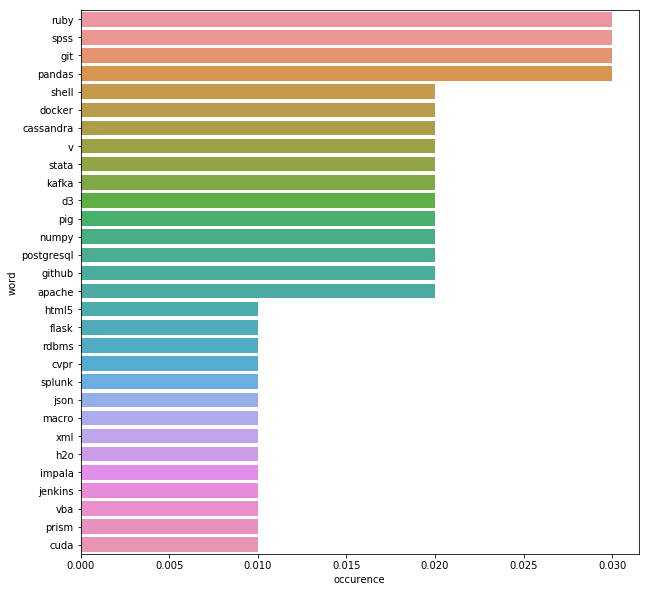

In [16]:
df_technologies = get_occurences_in_df(list_technologies,raw_data)
f, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=df_technologies[20:50], x='occurence', y='word')

Processed 0 of 29
Processed 10 of 29
Processed 20 of 29
done


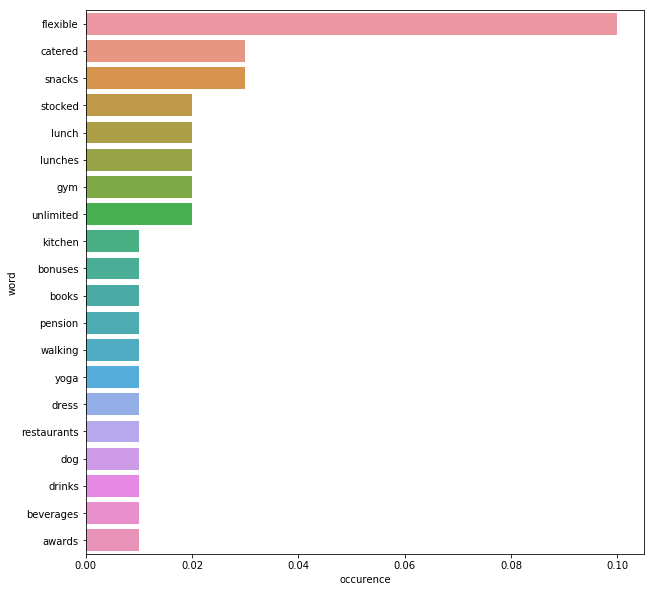

In [17]:
df_perks = get_occurences_in_df(list_perks,raw_data)
f, axes = plt.subplots(figsize=(10,10))
sns.barplot(data=df_perks[0:20], x='occurence', y='word')

Processed 0 of 52
Processed 10 of 52
Processed 20 of 52
Processed 30 of 52
Processed 40 of 52
Processed 50 of 52
done


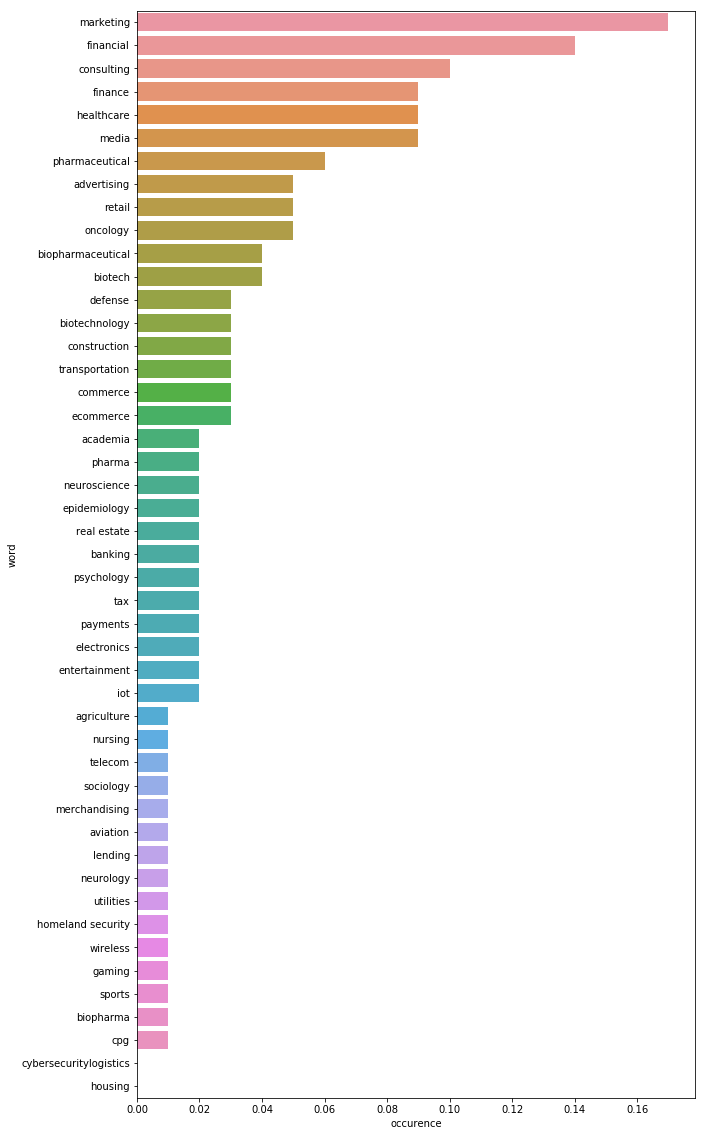

In [18]:
df_industries = get_occurences_in_df(list_industries,raw_data)
f, axes = plt.subplots(figsize=(10,20))
sns.barplot(data=df_industries[:], x='occurence', y='word')

In [25]:
%%time

exclude_words = ['high', 'quality', 'stronger', "we're", 'provides', 'management',
'environment', 'schedule', 'needs', 'world', 'class', 'complex', 'technical', '(nss)', 'operations',
            'results', 'effective', 'results', 'innovation', 'eoe', 'help', 'people', 'u', 'opportunity', 'relationship'
'ball', 'lead', 'industry', 'leading', 'provide', 'multiple', 'manage', 'work', "'", 'll', 'apply', 'data' ]

from nltk.util import ngrams
DOC = ' '.join(raw_data.description)
DOC = re.sub('lunches','lunch', DOC)
DOC = re.sub('snacks','snack', DOC)
DOC = re.sub('[\.,;:?-]','', DOC)
DOC = re.sub('(&amp;)','&',DOC)


def ngram_filter(doc, word, n):
    tokens = doc.split()
    all_ngrams = ngrams(tokens, n)
    filtered_ngrams = [x for x in all_ngrams 
                       if word in x
                      and not x[0] in ENGLISH_STOP_WORDS
                      and not x[1] in ENGLISH_STOP_WORDS
                       and not x[2] in ENGLISH_STOP_WORDS
                       and not x[0] in exclude_words
                       and not x[1] in exclude_words
                      and not x[2] in exclude_words]      
    return filtered_ngrams



CPU times: user 493 ms, sys: 302 ms, total: 795 ms
Wall time: 1.29 s


In [20]:
from nltk.stem import WordNetLemmatizer
from string import punctuation
lemmatizer = WordNetLemmatizer()

def my_lemmatizer(doc):
    tokens = nltk.word_tokenize(doc)
    tokenlist = [lemmatizer.lemmatize(token) for token in tokens 
                if not token in punctuation]   #[',', '.', ';', '.', ':', '"', "'", '(', ')', '-']]    
    return(' '.join(tokenlist))

lemmatized_doc = my_lemmatizer(DOC)

print(len(lemmatized_doc))

24564601


processing streamline
processing negotiate
processing discover
processing build
processing optimize
processing update
processing extract
processing suggest
processing acquire
processing facilitate
processing conduct
processing formulate
processing develop
processing improve
processing work
processing determine
processing deliver
processing craft
processing contribute
processing enhance
processing feed
processing configure
processing investigate
processing adapt
processing transform
processing write
processing manipulate
processing evaluate
processing validate
processing debug
processing deploy
processing run
processing identify
processing capture
processing oversee
processing mine
processing select
processing apply
processing educate
processing organize
processing coordinate
processing establish
processing promote
processing implement
processing create
processing automate
processing troubleshoot
processing analyze
processing launch
processing complete
processing utilize
processing main

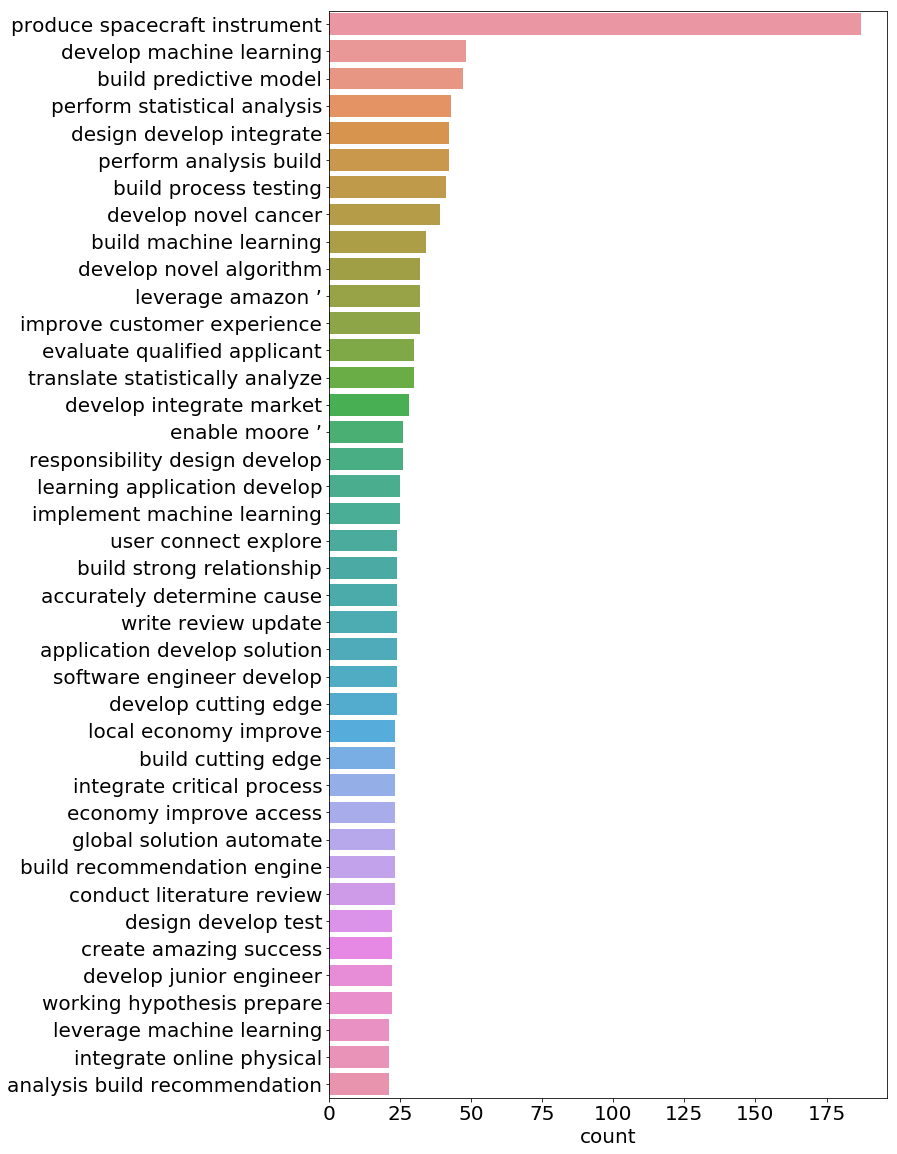

In [27]:
ngram_cnt = Counter()
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

list_roles_lemmatized = my_lemmatizer(' '.join(list_roles)).split()

perks_ngrams = []
for word in  list_roles_lemmatized: 
    print('processing ' + word)
    perks_ngrams = perks_ngrams + ngram_filter(lemmatized_doc, word, 3)

print('Done getting ngrams. Now counting them...')

for ngram in perks_ngrams:
    s = ngram[0] + ' ' + ngram[1] + ' ' + ngram[2]  # + ' ' + ngram[3]
    ngram_cnt[s] += 1
    
    
df_perks = pd.DataFrame.from_dict(dict(ngram_cnt), orient='index', columns=['count']).sort_values(by='count', ascending=False)

f, axes = plt.subplots(figsize=(10,20))
sns.barplot(data=df_perks[0:40], y=df_perks.index[0:40], x='count')

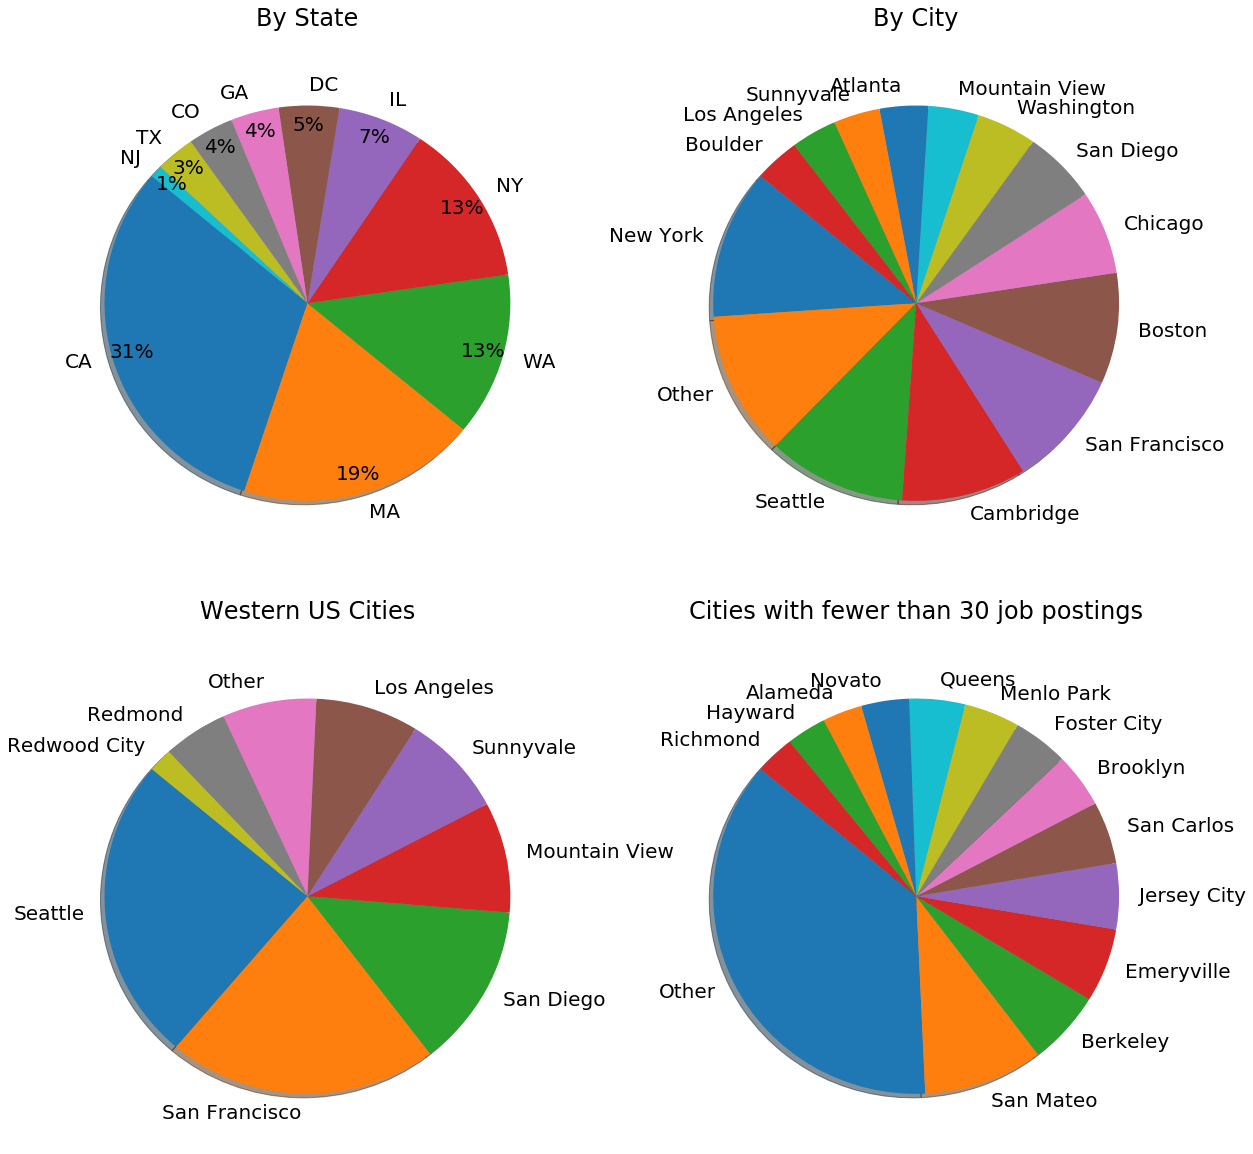

In [22]:
state_counts = pd.DataFrame(raw_data.state.value_counts())
#city_counts = pd.DataFrame(raw_data.city.value_counts())

city_counts = pd.DataFrame(raw_data.city.value_counts())
city_counts.reset_index(inplace=True)
city_counts.rename(columns={'index' : 'city', 'city':'count'}, inplace=True)  
city_counts.city.replace('Manhattan','New York', inplace=True)
city_counts.city = np.where(city_counts.index > 12, 'Other', city_counts.city)
city_counts = pd.DataFrame(city_counts.groupby(by='city').sum().sort_values(by='count', ascending=False))


east_counts = pd.DataFrame(raw_data.city[raw_data.state.isin(['CA','WA']) == False].value_counts())
east_counts.reset_index(inplace=True)
east_counts.rename(columns={'index' : 'city', 'city':'count'}, inplace=True)  
east_counts.city.replace('Manhattan','New York', inplace=True)
east_counts.city = np.where(east_counts.index > 8, 'Other', east_counts.city)
east_counts = pd.DataFrame(east_counts.groupby(by='city').sum().sort_values(by='count', ascending=False))

west_counts = pd.DataFrame(raw_data.city[raw_data.state.isin(['CA','WA'])].value_counts())
west_counts.reset_index(inplace=True)
west_counts.rename(columns={'index' : 'city', 'city':'count'}, inplace=True)  
west_counts.city.replace('Manhattan','New York', inplace=True)
west_counts.city = np.where(west_counts.index > 7, 'Other', west_counts.city)
west_counts = pd.DataFrame(west_counts.groupby(by='city').sum().sort_values(by='count', ascending=False))

small_cities = pd.DataFrame(raw_data.city.value_counts())
small_cities.reset_index(inplace=True)
small_cities.rename(columns={'index' : 'city', 'city':'count'}, inplace=True)  
small_cities.city.replace('Manhattan','New York', inplace=True)
small_cities = pd.DataFrame(small_cities.groupby(by='city').sum().sort_values(by='count', ascending=False))
small_cities.reset_index(inplace=True)
small_cities.city = np.where((small_cities['count'] > 30) | (small_cities['count'] < 10), 'Other', small_cities.city)
small_cities = small_cities.loc[small_cities['count'] <= 30]
small_cities = pd.DataFrame(small_cities.groupby(by='city').sum().sort_values(by='count', ascending=False))



f, axes = plt.subplots(2, 2, figsize=(20,20))
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.titlepad'] = 30 

plt.subplot(221)
plt.title('By State')
plt.pie(x = state_counts, labels= state_counts.index, pctdistance=.9,  labeldistance=1.1,
         shadow=True, startangle=140, autopct='%1.f%%')  #autopct=lambda x: np.round(x/100*len(raw_data),0) )
 

plt.subplot(222)
plt.title('By City')
plt.pie(x = city_counts, labels= city_counts.index, pctdistance=.8,  labeldistance=1.1,
        shadow=True, startangle=140)  #autopct='%1.f%%'
 


plt.subplot(223)
plt.title('Western US Cities')
plt.pie(x = west_counts, labels= west_counts.index, pctdistance=.8,  labeldistance=1.1,
         shadow=True, startangle=140)
 

plt.subplot(224)
plt.title('Cities with fewer than 30 job postings')
plt.pie(x = small_cities, labels= small_cities.index, pctdistance=.8,  labeldistance=1.1,
         shadow=True, startangle=140)


plt.show()


([<matplotlib.patches.Wedge at 0x153922b70>,
 [Text(-1.01954,-0.412952,'CA'),
  Text(0.510302,-0.97447,'MA'),
  Text(1.09775,-0.0703074,'WA'),
  Text(0.770617,0.784951,'NY'),
  Text(0.134411,1.09176,'IL'),
  Text(-0.270277,1.06628,'GA'),
  Text(-0.547933,0.953818,'DC'),
  Text(-0.730533,0.822388,'TX'),
  Text(-0.799838,0.755155,'CO'),
  Text(-0.828692,0.723373,'NJ')])

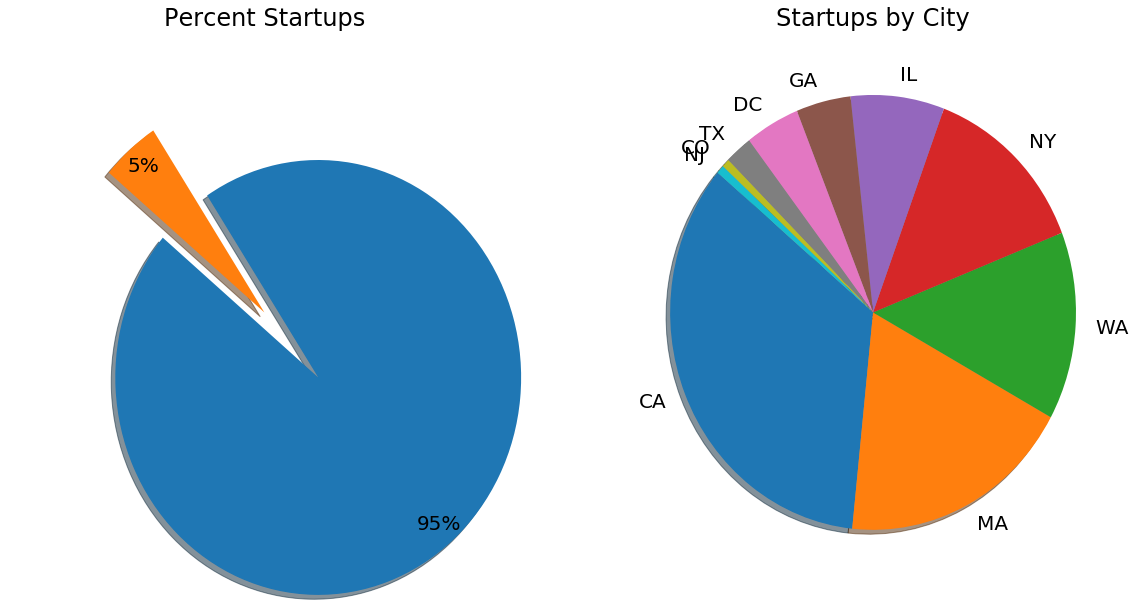

In [23]:
#===== Find the Startups, label them in the data, and graph them------

raw_data['startup'] = np.where(raw_data.description.str.contains('start up' or 'startup'), 1, 0)

f, axes = plt.subplots(1, 2, figsize=(20,10))
plt.rcParams.update({'font.size': 20})
plt.rcParams['axes.titlepad'] = 15 

plt.subplot(121)
plt.title('Percent Startups')
plt.pie(explode=[.4,0], x = raw_data.startup.value_counts(), pctdistance=.9,  labeldistance=1.1,
     shadow=True, startangle=140, autopct='%1.f%%')  #autopct=lambda x: np.round(x/100*len(raw_data),0) )
 

plt.subplot(122)
plt.title('Startups by City')
plt.pie(x = raw_data.loc[raw_data.startup == 1, 'state'].value_counts(), labels= raw_data.loc[raw_data.startup == 1, 'state'].value_counts().index, pctdistance=.8,  labeldistance=1.1,
        shadow=True, startangle=140)  #autopct='%1.f%%'
 

In [24]:
# def find_salary(row):
    
#     text = row.description
#     pattern = re.compile('([$]+\d+[\d,\.\s]*)[\.\sper]*(yr|hr|hour|day|dai|year|month|mth)?(ly)?')
    

#     matches = pattern.finditer(text)


#     output = ''
#     for match in matches:
#         a = match.group(0)
#         if a != None:
#             output = a
  
#     if output == '':
#         return 'Not Found'
#     else:
#         print(row.company)
#         print('-----------')
#         print(output)
#         return output



# raw_data['salary'] = raw_data.apply(find_salary, axis=1)

